In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import re
import numpy as np
import pandas as pd

from glob import glob

from src.dogFunctions import *
from src.imageTrans import plotGrid


from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, ELU, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2

Using TensorFlow backend.


In [2]:
def plotLosses( history ):
    """Plots training/validation loss as a fucntion of epoch."""

    fig = plt.figure( figsize = (18,10) )
    plt.plot( range(1, len(history["loss"]) + 1), history["loss"], "b-",
              linewidth = 3, label = "$\mathrm{training}$")
    plt.plot( range(1, len(history["val_loss"]) + 1), history["val_loss"], "g-",
              linewidth = 3, label = "$\mathrm{validation}$")
    plt.ylabel("$\mathrm{Loss}$")
    plt.xlabel("$\mathrm{Epoch}$")
    plt.legend( loc = "best" )

    plt.show()

    return

def plotAcc( history ):
    """Plots training/validation accuracy as a fucntion of epoch."""

    fig = plt.figure( figsize = (18,10) )
    plt.plot( range(1, len(history["acc"]) + 1), history["acc"], "b-",
              linewidth = 3, label = "$\mathrm{training}$")
    plt.plot( range(1, len(history["val_acc"]) + 1), history["val_acc"], "g-",
              linewidth = 3, label = "$\mathrm{validation}$")
    plt.ylabel("$\mathrm{Accuracy}$")
    plt.xlabel("$\mathrm{Epoch}$")
    plt.legend( loc = "best" )

    plt.show()

    return

def accurracy(X, y):
    
    preds = np.argmax( model.predict( X ), axis = 1 )
    y = np.argmax( y, axis = 1 )
    
    return np.sum( preds == y ) / len(y)

def denseBlock( x, size, dropout ):
    """Createsn one dense layer unit."""

    dense      = Dense( size, use_bias = False, activation = "elu" )( x )
    bn         = ELU()( BatchNormalization()(dense) )
    dropout    = Dropout( dropout )( bn )
    
    return dropout

def genModel( imgSize = 256, dropout = 0.5 ):
    """Generates the VAE model."""

    pretrained = InceptionResNetV2( input_shape = (imgSize, imgSize, 3), weights = 'imagenet',
                                    include_top = False )#, pooling = "avg" )
    inputLayer = pretrained.output

    flat = Flatten()( inputLayer )

    dense1 = denseBlock( flat,   1024, dropout )
    dense2 = denseBlock( dense1, 1024, dropout )
    dense3 = denseBlock( dense2, 1024,  dropout )
    dense4 = denseBlock( dense3, 1024, dropout )
    dense5 = denseBlock( dense4, 1024, dropout )

    outputLayer = Dense( 120, activation = "softmax" )( dense5 )

    for layer in pretrained.layers:
        layer.trainable = False

    opt = Adam() #Adam( lr = 0.1, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1.0 )

    model = Model( inputs = pretrained.input, outputs = outputLayer )
    model.compile( optimizer = opt, loss = "categorical_crossentropy", metrics = [ 'acc' ] )
    
    return model

In [3]:
trainFresh = False

breeds = readBreeds()
labels = pd.read_csv("labels.csv")

labels['breed'] = pd.Categorical( labels['breed'], categories = breeds )
labels['breed'] = labels['breed'].cat.codes
    
if ( trainFresh ):

    trainFiles = np.array( glob('./trainCrop/*.jpg') )
    
    valFiles = sampleDogs( trainFiles, labels, 0.147 )
    valFiles = np.array( list(set(valFiles)) )

    tmp = []
    
    for f in trainFiles:
        if ( not (f in valFiles) ):
            tmp.append(f)
            
    trainFiles = np.array( tmp )
    np.random.shuffle(trainFiles)

    writeFilesList( "trainFiles.txt", trainFiles )
    writeFilesList( "valFiles.txt", valFiles )

else:
    valFiles   = readSavedFiles( "valFiles.txt" )
    trainFiles = readSavedFiles( "trainFiles.txt" )

In [4]:
imgSize = 256
dropout = 0.75

model = genModel( imgSize, dropout )
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
batchSize = 64

#if ( not trainFresh ):
#    model.load_weights( "./best/dogClass.hdf5" )

earlyStopper = EarlyStopping( patience = 100, verbose = 1 )
checkPointer = ModelCheckpoint( filepath = "./best/dogClass.hdf5", save_best_only = True, verbose = 1 )

losses = model.fit_generator( genBatch( trainFiles, labels, batchSize, imgSize, True ),
                              steps_per_epoch = len(trainFiles) // batchSize,
                              validation_data = genBatch( valFiles, labels, batchSize, imgSize, False ),
                              validation_steps = len(valFiles) // batchSize,
                              epochs = 5000, callbacks = [ earlyStopper, checkPointer ] )

Epoch 1/5000
136/137 [============================>.] - ETA: 0s - loss: 6.9533 - acc: 0.0103
Epoch 00001: val_loss improved from inf to 4.54916, saving model to ./best/dogClass.hdf5
137/137 [==============================] - 157s 1s/step - loss: 6.9490 - acc: 0.0104 - val_loss: 4.5492 - val_acc: 0.0334
Epoch 2/5000
136/137 [============================>.] - ETA: 0s - loss: 6.2723 - acc: 0.0125
Epoch 00002: val_loss improved from 4.54916 to 4.00917, saving model to ./best/dogClass.hdf5
137/137 [==============================] - 100s 733ms/step - loss: 6.2713 - acc: 0.0125 - val_loss: 4.0092 - val_acc: 0.1341
Epoch 3/5000
136/137 [============================>.] - ETA: 0s - loss: 5.4650 - acc: 0.0353
Epoch 00003: val_loss improved from 4.00917 to 3.20645, saving model to ./best/dogClass.hdf5
137/137 [==============================] - 109s 798ms/step - loss: 5.4623 - acc: 0.0356 - val_loss: 3.2065 - val_acc: 0.2123
Epoch 4/5000
136/137 [============================>.] - ETA: 0s - loss: 4.

Epoch 29/5000
136/137 [============================>.] - ETA: 0s - loss: 1.6629 - acc: 0.5537
Epoch 00029: val_loss did not improve
137/137 [==============================] - 101s 736ms/step - loss: 1.6651 - acc: 0.5532 - val_loss: 0.5525 - val_acc: 0.8493
Epoch 30/5000
136/137 [============================>.] - ETA: 0s - loss: 1.6227 - acc: 0.5609
Epoch 00030: val_loss did not improve
137/137 [==============================] - 97s 709ms/step - loss: 1.6197 - acc: 0.5615 - val_loss: 0.5411 - val_acc: 0.8558
Epoch 31/5000
136/137 [============================>.] - ETA: 0s - loss: 1.5315 - acc: 0.5759
Epoch 00031: val_loss did not improve
137/137 [==============================] - 99s 724ms/step - loss: 1.5319 - acc: 0.5757 - val_loss: 0.5412 - val_acc: 0.8601
Epoch 32/5000
136/137 [============================>.] - ETA: 0s - loss: 1.5394 - acc: 0.5696
Epoch 00032: val_loss did not improve
137/137 [==============================] - 104s 757ms/step - loss: 1.5378 - acc: 0.5701 - val_loss:

136/137 [============================>.] - ETA: 0s - loss: 1.3166 - acc: 0.6411
Epoch 00060: val_loss did not improve
137/137 [==============================] - 101s 738ms/step - loss: 1.3227 - acc: 0.6397 - val_loss: 0.5238 - val_acc: 0.8630
Epoch 61/5000
136/137 [============================>.] - ETA: 0s - loss: 1.2939 - acc: 0.6447
Epoch 00061: val_loss improved from 0.47992 to 0.40948, saving model to ./best/dogClass.hdf5
137/137 [==============================] - 103s 755ms/step - loss: 1.2929 - acc: 0.6443 - val_loss: 0.4095 - val_acc: 0.8826
Epoch 62/5000
136/137 [============================>.] - ETA: 0s - loss: 1.2897 - acc: 0.6440
Epoch 00062: val_loss did not improve
137/137 [==============================] - 99s 721ms/step - loss: 1.2865 - acc: 0.6447 - val_loss: 0.5104 - val_acc: 0.8761
Epoch 63/5000
136/137 [============================>.] - ETA: 0s - loss: 1.3022 - acc: 0.6372
Epoch 00063: val_loss did not improve
137/137 [==============================] - 97s 707ms/step

Epoch 92/5000
136/137 [============================>.] - ETA: 0s - loss: 1.0396 - acc: 0.7059
Epoch 00092: val_loss did not improve
137/137 [==============================] - 102s 741ms/step - loss: 1.0426 - acc: 0.7053 - val_loss: 0.4889 - val_acc: 0.8775
Epoch 93/5000
136/137 [============================>.] - ETA: 0s - loss: 1.1471 - acc: 0.6884
Epoch 00093: val_loss did not improve
137/137 [==============================] - 101s 741ms/step - loss: 1.1452 - acc: 0.6889 - val_loss: 0.4742 - val_acc: 0.8729
Epoch 94/5000
136/137 [============================>.] - ETA: 0s - loss: 1.0873 - acc: 0.6993
Epoch 00094: val_loss did not improve
137/137 [==============================] - 97s 709ms/step - loss: 1.0869 - acc: 0.6995 - val_loss: 0.4839 - val_acc: 0.8797
Epoch 95/5000
136/137 [============================>.] - ETA: 0s - loss: 1.0160 - acc: 0.7145
Epoch 00095: val_loss did not improve
137/137 [==============================] - 101s 738ms/step - loss: 1.0192 - acc: 0.7139 - val_loss

Epoch 124/5000
136/137 [============================>.] - ETA: 0s - loss: 0.8846 - acc: 0.7551
Epoch 00124: val_loss did not improve
137/137 [==============================] - 104s 758ms/step - loss: 0.8853 - acc: 0.7550 - val_loss: 0.4834 - val_acc: 0.8783
Epoch 125/5000
136/137 [============================>.] - ETA: 0s - loss: 0.9419 - acc: 0.7397
Epoch 00125: val_loss did not improve
137/137 [==============================] - 98s 719ms/step - loss: 0.9416 - acc: 0.7399 - val_loss: 0.5358 - val_acc: 0.8754
Epoch 126/5000
136/137 [============================>.] - ETA: 0s - loss: 0.8626 - acc: 0.7521
Epoch 00126: val_loss did not improve
137/137 [==============================] - 95s 691ms/step - loss: 0.8599 - acc: 0.7529 - val_loss: 0.4420 - val_acc: 0.8848
Epoch 127/5000
136/137 [============================>.] - ETA: 0s - loss: 0.9840 - acc: 0.7323
Epoch 00127: val_loss did not improve
137/137 [==============================] - 104s 756ms/step - loss: 0.9878 - acc: 0.7312 - val_l

Epoch 156/5000
136/137 [============================>.] - ETA: 0s - loss: 0.9076 - acc: 0.7517
Epoch 00156: val_loss did not improve
137/137 [==============================] - 97s 711ms/step - loss: 0.9062 - acc: 0.7518 - val_loss: 0.4735 - val_acc: 0.8790
Epoch 157/5000
136/137 [============================>.] - ETA: 0s - loss: 0.9024 - acc: 0.7574
Epoch 00157: val_loss did not improve
137/137 [==============================] - 104s 756ms/step - loss: 0.9025 - acc: 0.7570 - val_loss: 0.5313 - val_acc: 0.8797
Epoch 158/5000
136/137 [============================>.] - ETA: 0s - loss: 0.9939 - acc: 0.7377
Epoch 00158: val_loss did not improve
137/137 [==============================] - 101s 736ms/step - loss: 0.9957 - acc: 0.7369 - val_loss: 0.5002 - val_acc: 0.8768
Epoch 159/5000
136/137 [============================>.] - ETA: 0s - loss: 0.8454 - acc: 0.7588
Epoch 00159: val_loss did not improve
137/137 [==============================] - 99s 725ms/step - loss: 0.8436 - acc: 0.7590 - val_l

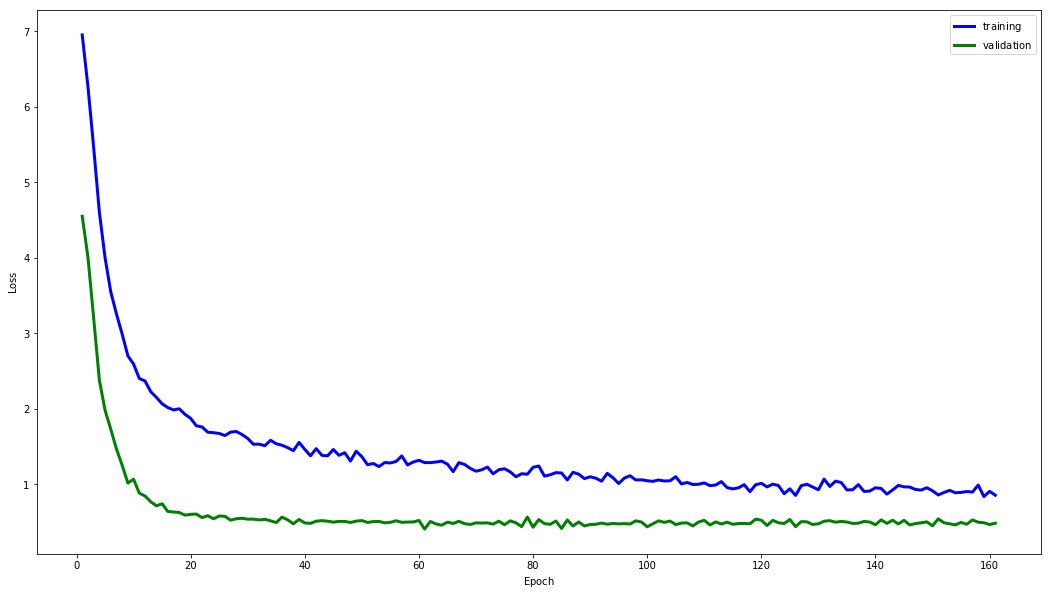

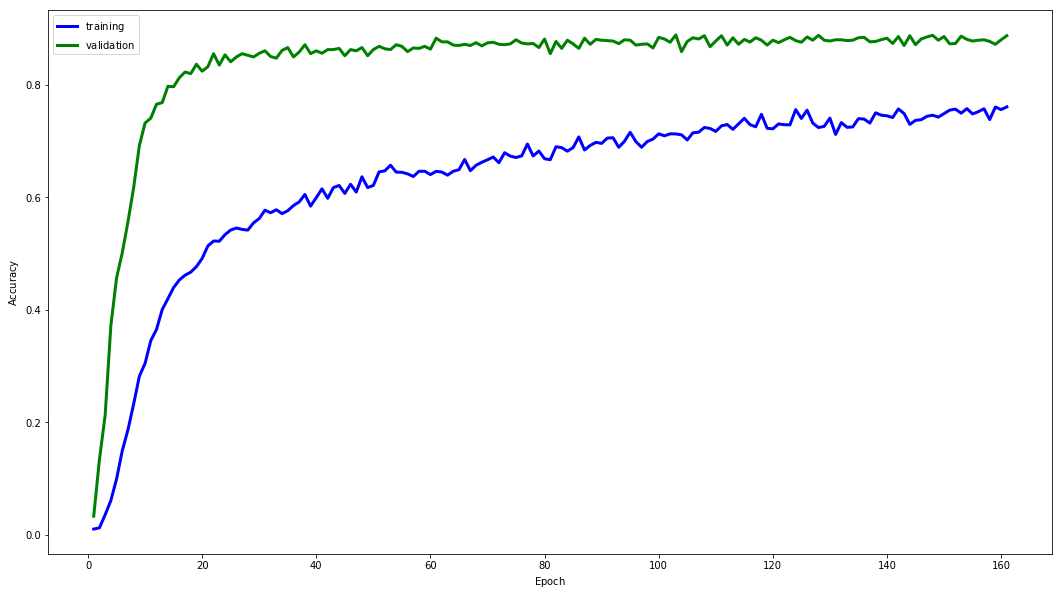

In [6]:
plotLosses( losses.history )
plotAcc( losses.history )

In [7]:
imgSize = 256
dropout = 0.80

model = genModel( imgSize, dropout )
model.load_weights(  "./best/dogClass.hdf5" )

In [8]:
testFiles  = np.array( glob('./testCroped/*.jpg') )

def getImage( file, size = 256 ):
    """Loads a single image with its ID code."""

    imgID = getImageId( file )
    img = image.load_img( file, target_size = (size, size) )
    img = image.img_to_array(img)/255

    return imgID, img

ids = []
predictions = []

for f in testFiles:
    imgID, img = getImage(f)
    
    pred = model.predict( np.array([img]) )
    
    ids.append( imgID )
    predictions.append( pred[0] )

ids = np.array(ids)
predictions = np.array( predictions )

print( predictions.shape )

(10357, 120)


In [9]:
testData = pd.DataFrame( predictions, columns = breeds, index = ids )
testData.index.name = "id"

In [10]:
testData.to_csv( "testRes.csv" )